<a href="https://colab.research.google.com/github/KrishVor4/dso-560-nlp-text-analytics/blob/main/Sentiment_Analysis_GTA_V_Krish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEAM BLACK - NLP PROJECT
### 1. Jewon Ju
### 2. Krish Vora
### 3. Matthew Lee

## Sentiment Analysis

### Importing Libraries

In [1]:
import pandas as pd
import textacy
import matplotlib.pyplot as plt
import seaborn as sns
from textacy.preprocessing.remove import punctuation
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
import nltk
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import SimpleRNN
from keras.layers import Flatten, Masking
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Data Exploration

In [2]:
from google.colab import files
uploaded = files.upload()

Saving gta_data.csv to gta_data (1).csv


In [3]:
#reading in data
df = pd.read_csv("gta_data.csv")

In [4]:
#exploring the data
df.head()

,Unnamed: 0,Unnamed: 0.1,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,12750210,12750213,271590,Grand Theft Auto V,84998143,english,It's fun.\nWish the loading times for Online w...,1611091317,1611091317,True,...,True,False,False,76561198150307046,21,8,9894.0,51.0,9894.0,1.610902e+09
1,12750213,12750216,271590,Grand Theft Auto V,84997804,english,hn,1611090858,1611090858,True,...,True,False,False,76561199116756419,2,1,1935.0,700.0,1920.0,1.611091e+09
2,12750214,12750217,271590,Grand Theft Auto V,84997454,english,---{Graphics}---\n☐ You forget what reality is...,1611090369,1611090369,True,...,True,False,False,76561198153251963,186,10,34944.0,899.0,34944.0,1.610992e+09
3,12750216,12750219,271590,Grand Theft Auto V,84996934,english,a,1611089687,1611089687,True,...,True,False,False,76561198311729059,16,1,1817.0,549.0,1817.0,1.611089e+09
4,12750223,12750226,271590,Grand Theft Auto V,84996088,english,It is one of the best games I’ve played.. Too ...,1611088541,1611088541,True,...,True,False,False,76561198883017613,9,1,5263.0,0.0,5263.0,1.609456e+09


In [5]:
#seeing columns
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'app_id', 'app_name', 'review_id',
       'language', 'review', 'timestamp_created', 'timestamp_updated',
       'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

In [6]:
#dropping irrelevant columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'app_id', 'app_name', 'review_id',
       'language', 'timestamp_created', 'timestamp_updated',
    'votes_helpful', 'votes_funny', 'weighted_vote_score',
       'comment_count', 'steam_purchase', 'received_for_free',
       'written_during_early_access', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'], axis = 1, inplace= True)

In [7]:
df.head()

,review,recommended
0,It's fun.\nWish the loading times for Online w...,True
1,hn,True
2,---{Graphics}---\n☐ You forget what reality is...,True
3,a,True
4,It is one of the best games I’ve played.. Too ...,True


In [8]:
#shape of our dataframe
df.shape

(319751, 2)

In [9]:
#information about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319751 entries, 0 to 319750
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review       319099 non-null  object
 1   recommended  319751 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 2.7+ MB


Text(0.5, 1.0, 'Counts of recommendations')

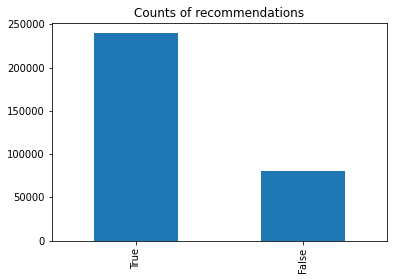

In [10]:
#plotting distribution of recommendations
df['recommended'].value_counts().plot(kind='bar')
plt.title("Counts of recommendations")

### Data Preparation and Pre-Processing

In [11]:
#labelling 1 and 0 for recommendations
df['recommend'] = df['recommended'].apply(lambda x: 1 if x == True else 0)

In [12]:
df.sample(5)

,review,recommended,recommend
123031,yes,True,1
52153,connection issues makes me sick,False,0
256892,PUTANGINA ANG LUFET NITO MGA GAGO,True,1
117254,I like the knew stuff for the game online.\n,True,1
218723,Shitty game that wants to take all your money ...,False,0


In [13]:
#dropping rows with NA values
df.dropna(inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319099 entries, 0 to 319750
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review       319099 non-null  object
 1   recommended  319099 non-null  bool  
 2   recommend    319099 non-null  int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 7.6+ MB


In [15]:
#convert to lowercase 
df['cleaned_reviews'] = df['review'].map(lambda x: x.lower())

In [16]:
df.head()

,review,recommended,recommend,cleaned_reviews
0,It's fun.\nWish the loading times for Online w...,True,1,it's fun.\nwish the loading times for online w...
1,hn,True,1,hn
2,---{Graphics}---\n☐ You forget what reality is...,True,1,---{graphics}---\n☐ you forget what reality is...
3,a,True,1,a
4,It is one of the best games I’ve played.. Too ...,True,1,it is one of the best games i’ve played.. too ...


In [17]:
#stopwords using nltk stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#removing stopwords
stop = stopwords.words('english')
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [19]:
#regex to remove \n, multiples spaces b/w words, grouping different represenations of 5 and GTA
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: re.sub("\n","",x))
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: re.sub("\s+"," ",x))
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: re.sub("\bgta\b|\bgta\s?v\b|\bgrand theft auto\b|\bgrand theft\b|\bgta\s?5\b","GTA",x))
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: re.sub("\bv\b|\b5\b|\bfive\b","FIVE",x))


In [20]:
#replace common entities/concept 
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
df["cleaned_reviews"] = df['cleaned_reviews'].\
  apply(urls).\
  apply(hashtags).\
  apply(currency_symbols).\
  apply(emojis).\
  apply(emails).\
  apply(numbers)

In [21]:
#remove punctuation
df["cleaned_reviews"] = df['cleaned_reviews'].apply(punctuation)

In [22]:
df.head()

,review,recommended,recommend,cleaned_reviews
0,It's fun.\nWish the loading times for Online w...,True,1,fun wish loading times online better also l...
1,hn,True,1,hn
2,---{Graphics}---\n☐ You forget what reality is...,True,1,graphics EMOJI forget reality EMOJI...
3,a,True,1,
4,It is one of the best games I’ve played.. Too ...,True,1,one best games i ve played bad online mode f...


### Logistic Regression using Tfid Vectorizer

In [23]:
#creating a vectorizer object
vectorizer = TfidfVectorizer()

In [24]:
#creating X and y dataframes
X = vectorizer.fit_transform(df["cleaned_reviews"])
y = df["recommend"]

In [25]:
#splitting data into 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, test_size = 0.3)

In [26]:
#creating a Logistic Regression object
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [27]:
#get confusion matrix
confusion_matrix(y_test, y_pred,  normalize="true")

array([[0.73246295, 0.26753705],
       [0.04373583, 0.95626417]])

In [28]:
#getting the roc score, accuracy and the f1 score
print(f'ROC AUC Score: {round(roc_auc_score(y_test, y_pred, multi_class="ovo")*100,3)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred, average= "weighted")*100,3)}%')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%')

ROC AUC Score: 84.436%
F1 Score: 89.805%
Accuracy: 90.06%


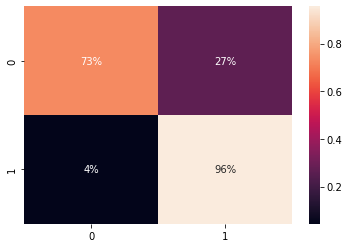

In [29]:
#plotting a confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt= ".0%", ax=ax)

### Random Forest using CountVectorizer

In [30]:
#creating a vectorizer object
vectorizer = CountVectorizer()

In [31]:
#creating X and y dataframes
X = vectorizer.fit_transform(df["cleaned_reviews"])
y = df["recommend"]

In [32]:
#splitting data into 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, test_size = 0.3)

In [33]:
#creating a Random Forest object
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [34]:
#get confusion matrix
confusion_matrix(y_test, y_pred,  normalize="true")

array([[0.73703875, 0.26296125],
       [0.05433256, 0.94566744]])

In [35]:
#getting the roc score, accuracy and the f1 score
print(f'ROC AUC Score: {round(roc_auc_score(y_test, y_pred, multi_class="ovo")*100,3)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred, average= "weighted")*100,3)}%')
print(f'Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%')

ROC AUC Score: 84.135%
F1 Score: 89.184%
Accuracy: 89.38%


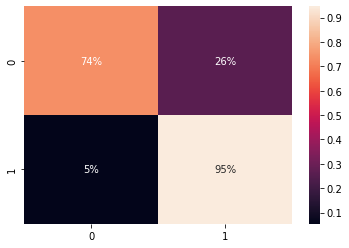

In [36]:
#plotting a confusion matrix
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt= ".0%", ax=ax)

### Recurrent Neural Network

In [37]:
#tokenize text
tokenizer = Tokenizer(oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(df['cleaned_reviews'])

In [38]:
#defining max length
MAX_SEQUENCE_LENGTH = 100

In [39]:
#encoding and padding documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# integer encode the documents
encoded_docs = integer_encode_documents(df['cleaned_reviews'], tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [40]:
#encoding labels
labels = np.array(df['recommend'])
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [41]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.3)

In [42]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

In [43]:
#defining rnn function
def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [44]:
#defining model
model_rnn = make_binary_classification_rnn_model()
print(model_rnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          12967200  
                                                                 
 masking (Masking)           (None, 100, 100)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12,978,834
Trainable params: 11,634
Non-trainable params: 12,967,200
_________________________________________________________________


In [45]:
#training the model
history_rnn = model_rnn.fit(X_train, y_train,validation_split = 0.1, epochs=2, verbose=1)

Epoch 1/2
6283/6283 [==============================] - 297s 47ms/step - loss: 0.5549 - accuracy: 0.7479 - val_loss: 0.4757 - val_accuracy: 0.7564
Epoch 2/2
6283/6283 [==============================] - 298s 47ms/step - loss: 0.4696 - accuracy: 0.7589 - val_loss: 0.4548 - val_accuracy: 0.7756


In [46]:
#evaluating the model
loss, accuracy = model_rnn.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2992/2992 [==============================] - 46s 15ms/step - loss: 0.4559 - accuracy: 0.7723
Accuracy: 77.227622
